## Notebook para analise exploratória e estatistica dos dados de "Overview" extraidos do site VLR.GG

### Hipoteses:
- DAODS DE MAPAS
- DADOS DE MATCHES

In [1]:
## Import functions for Data Scraping, Treatment and Plotting

## System
import re
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## EDA
import numpy as np
import pandas as pd

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


In [2]:
## FUNCIONS

## IMPORT DATA FROM CSV FILE
def ImportData(team_file):
    folder = team_file + '/'
    maps_file = team_file + '_overview_MAPS.csv'
    matches_file = team_file + '_overview_MATCHES.csv'
    
    maps = pd.read_csv(CSV_PATH + folder + maps_file)
    matches = pd.read_csv(CSV_PATH + folder + matches_file)

    return maps, matches

## Get Map data for all teams
def AllTeamsMaps(files, teams):
    concat = pd.concat([ImportData(team_file)[0] for team_file in files])
    filter = FilterTeam(concat, teams)
    filter.Team[filter.Team == 'NOOR'] = 'paiN'
    filter.Team[filter.Team == 'Mix'] = 'IMP'
    filter.Team[filter.Team == 'NMDM'] = 'Inga'
    filter.Team[filter.Team == 'FF'] = 'VORA'
    ExtraInfoMaps(filter)
    return filter

## Get Match data for all teams
def AllTeamsMatches(files, teams):
    concat = pd.concat([ImportData(team_file)[1] for team_file in files])
    filter = FilterTeam(concat, teams)
    filter.Team[filter.Team == 'NOOR'] = 'paiN'
    filter.Team[filter.Team == 'Mix'] = 'IMP'
    filter.Team[filter.Team == 'NMDM'] = 'Inga'
    filter.Team[filter.Team == 'FF'] = 'VORA'
    ExtraInfoMatches(filter)
    return filter

## ADD EXTRA INFO TO MATCHES DATAFRAME
def ExtraInfoMatches(df):
    # KDA + FK/FD per map
    df['KPM'] = round(df['K'] / df['Num_maps'],2)
    df['DPM'] = round(df['D'] / df['Num_maps'],2)
    df['APM'] = round(df['A'] / df['Num_maps'],2)
    df['FKPM'] = round(df['FK'] / df['Num_maps'],2)
    df['FDPM'] = round(df['FD'] / df['Num_maps'],2)

## ADD EXTRA INFO TO MAPS DATAFRAME
def ExtraInfoMaps(df):

    # Total Rounds
    df['total_rounds'] = df['rounds_won'] + df['rounds_lost']

    # Round Win Rate
    df['win_rate'] = round(df['rounds_won'] / df['total_rounds'] * 100, 2)

    # KDA + FK/FD per Round
    df['KPR'] = round(df['K'] / df['total_rounds'],2)
    df['DPR'] = round(df['D'] / df['total_rounds'],2)
    df['APR'] = round(df['A'] / df['total_rounds'],2)
    df['FKPR'] = round(df['FK'] / df['total_rounds'],2)
    df['FDPR'] = round(df['FD'] / df['total_rounds'],2)

    # Won/Lost Map
    df['RESULT'] = ['W' if x == True
                    else 'L'
                    for x in df['rounds_won'] > df['rounds_lost']]

## FILTER FUNCTIONS BY GIVEN OPPONENT/MAP/PLAYER/AGENT

def FilterTeam(df, teams):
    return df[df["Team"].isin(teams)].reset_index(drop=True)

def FilterOppTeam(df, opp_teams):
    return df[df["Opp_Team"].isin(opp_teams)].reset_index(drop=True)

def FilterMap(df, maps):
    return df[df["Map"].isin(maps)].reset_index(drop=True)

def FilterPlayer(df, players):
    return df[df["Player"].isin(players)].reset_index(drop=True)

def FilterAgent(df, agents):
    return df[df["Agents"].isin(agents)].reset_index(drop=True)

def Preprocessamento(team, team_file):
    ## Import data
    maps, matches = ImportData(team_file)

    ## Add Extra Info
    ExtraInfoMaps(maps)
    ExtraInfoMatches(matches)

    ## Filter Team
    matches = FilterTeam(matches, team)
    maps = FilterTeam(maps, team)

    ## Padrozinar nome do time
    maps.Team  = team_file
    matches.Team  = team_file

    return maps, matches

## CORRELATION OF GIVEN FEATURE WITH NUMBER OF ROUNDS WON
def WinCorr(df, stats, filter_maps = None):
    if filter_maps is not None:
        df = FilterMap(df, filter_maps)
    group = maps.groupby('rounds_won').mean()[stats].reset_index()
    corr_pearson = (group.corr())['rounds_won'][stats]
    corr_spearman = (group.corr(method='spearman'))['rounds_won'][stats]
    corr_kendall = (group.corr(method='kendall'))['rounds_won'][stats]
    print("Correlação Pearson média({0}) por Rounds Vencidos: {1}".format(stats, round(corr_pearson, 2)))
    print("Correlação Spearman média({0}) por Rounds Vencidos: {1}".format(stats, round(corr_spearman, 2)))
    print("Correlação Kendall média({0}) por Rounds Vencidos: {1}".format(stats, round(corr_kendall, 2)))

## CREATE DICT WITH MULTIPLE DATAFRAMES BY FILTERED VALUES
def FilterDict(col):
    aux = {}
    names = maps[col].unique()
    for name in names:
        aux[name] = maps[maps[col] == name].reset_index(drop=True)
    return aux

def Boxplot(nome_col, value):
    sns.set(rc={'figure.figsize':(12,7)})
    sns.boxplot(x=maps[nome_col], y=maps[value], order=maps[nome_col].sort_values().unique())

def Histogram(data ,value_col, filter):
    sns.set(rc={'figure.figsize':(12,7)})
    sns.displot(data=data, x=value_col, col=filter)

def PlotAgentPickRate(df):
    for i, map in enumerate(MAPS):
        filter = FilterMap(df, [map])
        agent_pick_rate = filter['Agents'].value_counts() / (len(filter) / 5)  * 100
        plt.figure(i, figsize=(10,))
        sns.barplot(y=agent_pick_rate.index, x=agent_pick_rate.values, palette="Blues_d").set_title('Agent Pick Rate -- '+map+' -- Played: '+str(int(len(filter) / 5))+' times')

In [3]:
stats_cols = ['ACS'	,'K','D','A','KD_DIFF','ADR','HS%','FK','FD',	
              'FK_FD_DIFF', 'KPR', 'DPR', 'APR', 'FKPR',                  
              'FDPR', 'rounds_won', 'rounds_lost', 'total_rounds'] 

In [4]:
## TEAMS: ['GL', 'IMP', 'Mix', 'HAVAN', 'Inga', 'NMDM', 'VKS', 'FF', 'VORA', 'BD', 'paiN', 'NOOR']
    # IMP = Mix; Inga = NMDM; FF = VORA; paiN = NOOR 
## team_files: gamelanders, pain, vorax, havan, imperial, ingaming, vikings, black_dragons
CSV_PATH = '../data/csv/'
EXCEL_PATH = '..data/excel/'

TEAM = ['paiN', 'NOOR']
TEAM_FILE = 'pain'

ALL_FILES = ['gamelanders', 'pain', 'vorax', 'havan', 'imperial', 'ingaming', 'vikings', 'black_dragons']
ALL_TEAMS = ['GL', 'IMP','Mix', 'HAVAN', 'Inga', 'NMDM', 'VKS', 'FF', 'VORA', 'BD', 'paiN','NOOR']
MAPS = ['ASCENT', 'BIND', 'HAVEN', 'ICEBOX', 'SPLIT']

### All Teams Data

In [86]:
all_maps = AllTeamsMaps(ALL_FILES, ALL_TEAMS)
all_matches = AllTeamsMatches(ALL_FILES, ALL_TEAMS)

In [90]:
maps, matches = Preprocessamento(TEAM, TEAM_FILE)

In [82]:
#maps = FilterTeam(maps,)
#maps = FilterMap(maps,)
#maps = FilterPlayer(maps,)
#maps = FilterAgent(maps,)

In [89]:
all_maps

,Player,Agents,ACS,K,D,A,KD_DIFF,ADR,HS%,FK,...,Map,Patch,total_rounds,win_rate,KPR,DPR,APR,FKPR,FDPR,RESULT
0,Jonn,jett,398,22,9,5,13,224.6,18,3,...,SPLIT,1.12,16,81.25,1.38,0.56,0.31,0.19,0.06,W
1,mwzera,raze,268,14,12,5,2,181.0,17,2,...,SPLIT,1.12,16,81.25,0.88,0.75,0.31,0.12,0.06,W
2,JhoW,omen,185,13,8,7,5,103.9,19,1,...,SPLIT,1.12,16,81.25,0.81,0.50,0.44,0.06,0.06,W
3,fznnn,cypher,155,8,9,9,-1,83.6,14,1,...,SPLIT,1.12,16,81.25,0.50,0.56,0.56,0.06,0.31,W
4,Nyang,breach,131,8,10,3,-2,66.6,15,0,...,SPLIT,1.12,16,81.25,0.50,0.62,0.19,0.00,0.06,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,NikkoLAN,jett,280,18,10,1,8,163.6,27,3,...,ASCENT,1.08,17,76.47,1.06,0.59,0.06,0.18,0.06,W
1866,rhz,sova,270,18,9,8,9,168.6,30,3,...,ASCENT,1.08,17,76.47,1.06,0.53,0.47,0.18,0.12,W
1867,fooX,reyna,228,15,11,3,4,121.5,29,2,...,ASCENT,1.08,17,76.47,0.88,0.65,0.18,0.12,0.12,W
1868,RoY,cypher,168,9,13,6,-4,105.5,16,1,...,ASCENT,1.08,17,76.47,0.53,0.76,0.35,0.06,0.06,W


In [83]:
print(matches.columns)
matches.head()

Index(['Player', 'ACS', 'K', 'D', 'A', 'KD_DIFF', 'ADR', 'HS%', 'FK', 'FD',
       'FK_FD_DIFF', 'match_id', 'Team', 'Opp_Team', 'Map', 'Num_maps',
       'Patch', 'KPM', 'DPM', 'APM', 'FKPM', 'FDPM'],
      dtype='object')


,Player,ACS,K,D,A,KD_DIFF,ADR,HS%,FK,FD,...,Team,Opp_Team,Map,Num_maps,Patch,KPM,DPM,APM,FKPM,FDPM
0,kon4n,244,52,35,23,17,161.6,25,5,2,...,pain,IMP,MATCH,3,NaN,17.33,11.67,7.67,1.67,0.67
1,Txozin,244,57,43,6,14,145.3,32,7,3,...,pain,IMP,MATCH,3,NaN,19.00,14.33,2.00,2.33,1.00
2,murizzz,211,37,49,23,-12,132.7,20,12,4,...,pain,IMP,MATCH,3,NaN,12.33,16.33,7.67,4.00,1.33
3,Veroneze,183,39,44,11,-5,128.5,29,8,6,...,pain,IMP,MATCH,3,NaN,13.00,14.67,3.67,2.67,2.00
4,matheuzin,160,37,43,4,-6,103.1,28,9,6,...,pain,IMP,MATCH,3,NaN,12.33,14.33,1.33,3.00,2.00


In [85]:
matches.match_id.nunique()

22

In [91]:
print(maps.columns)
maps

Index(['Player', 'Agents', 'ACS', 'K', 'D', 'A', 'KD_DIFF', 'ADR', 'HS%', 'FK',
       'FD', 'FK_FD_DIFF', 'match_id', 'Team', 'Opp_Team', 'rounds_won',
       'rounds_lost', 'Map', 'Patch', 'total_rounds', 'win_rate', 'KPR', 'DPR',
       'APR', 'FKPR', 'FDPR', 'RESULT'],
      dtype='object')


,Player,Agents,ACS,K,D,A,KD_DIFF,ADR,HS%,FK,...,Map,Patch,total_rounds,win_rate,KPR,DPR,APR,FKPR,FDPR,RESULT
0,kon4n,sage,330,21,8,7,13,180.9,19,3,...,ASCENT,NaN,18,72.22,1.17,0.44,0.39,0.17,0.00,W
1,murizzz,sova,246,14,11,10,3,135.7,12,4,...,ASCENT,NaN,18,72.22,0.78,0.61,0.56,0.22,0.00,W
2,Txozin,omen,237,17,11,2,6,139.1,28,1,...,ASCENT,NaN,18,72.22,0.94,0.61,0.11,0.06,0.06,W
3,Veroneze,jett,189,13,13,3,0,102.2,26,3,...,ASCENT,NaN,18,72.22,0.72,0.72,0.17,0.17,0.17,W
4,matheuzin,cypher,137,10,11,0,-1,88.0,35,2,...,ASCENT,NaN,18,72.22,0.56,0.61,0.00,0.11,0.06,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,kon4n,raze,358,24,13,5,11,274.5,19,5,...,SPLIT,1.09,20,65.00,1.20,0.65,0.25,0.25,0.00,W
236,murizzz,jett,223,16,15,7,1,140.0,12,5,...,SPLIT,1.09,20,65.00,0.80,0.75,0.35,0.25,0.05,W
237,matheuzin,cypher,166,13,12,5,1,120.3,33,2,...,SPLIT,1.09,20,65.00,0.65,0.60,0.25,0.10,0.20,W
238,Txozin,omen,163,13,13,9,0,106.3,22,1,...,SPLIT,1.09,20,65.00,0.65,0.65,0.45,0.05,0.00,W


In [33]:
player_dict = FilterDict('Player')
agent_dict = FilterDict('Agents')
map_dict = FilterDict('Map')

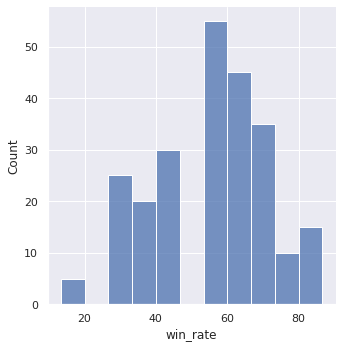

In [51]:
Histogram(maps, "win_rate", None)

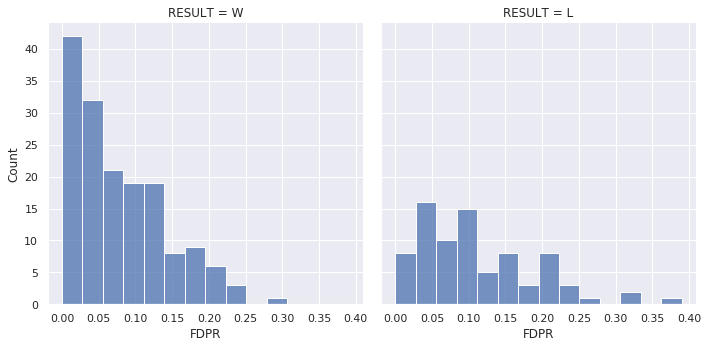

In [52]:
Histogram(maps, "FDPR", 'RESULT')

In [47]:
WinCorr(maps, 'FKPR')

Correlação Pearson média(FKPR) por Rounds Vencidos: 0.93
Correlação Spearman média(FKPR) por Rounds Vencidos: 0.9
Correlação Kendall média(FKPR) por Rounds Vencidos: 0.76


In [48]:
WinCorr(maps, 'FDPR')

Correlação Pearson média(FDPR) por Rounds Vencidos: -0.92
Correlação Spearman média(FDPR) por Rounds Vencidos: -0.9
Correlação Kendall média(FDPR) por Rounds Vencidos: -0.78


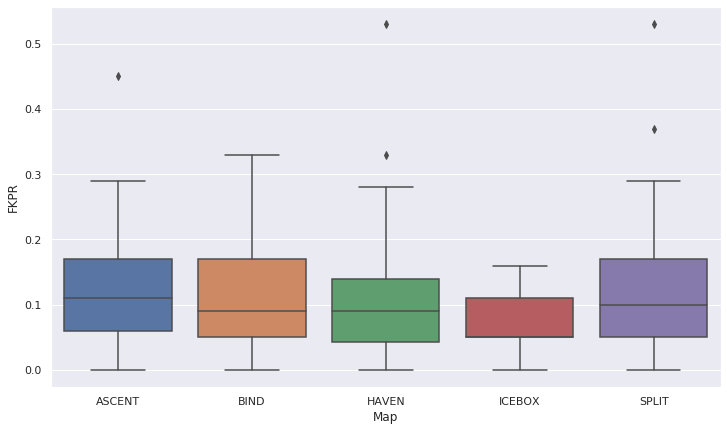

In [48]:
Boxplot('Map', 'FKPR')

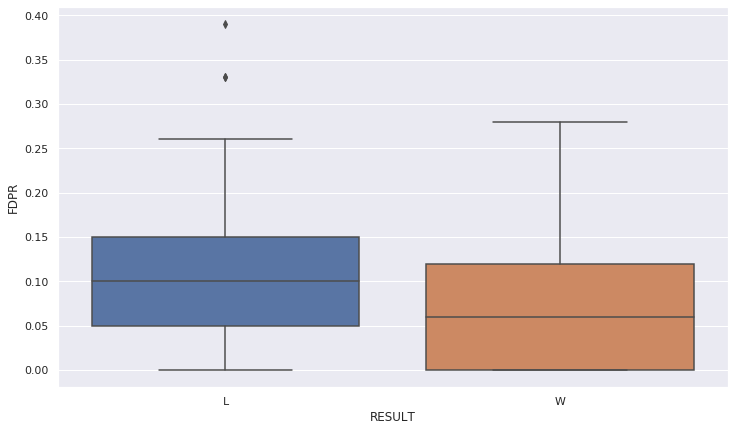

In [50]:
Boxplot('RESULT', 'FDPR')

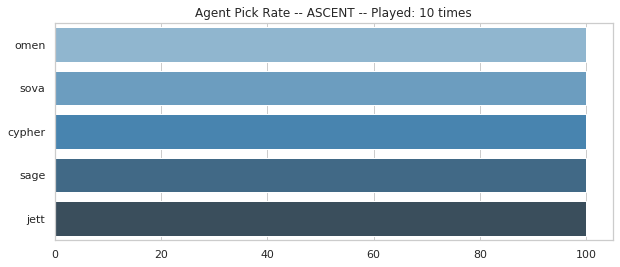

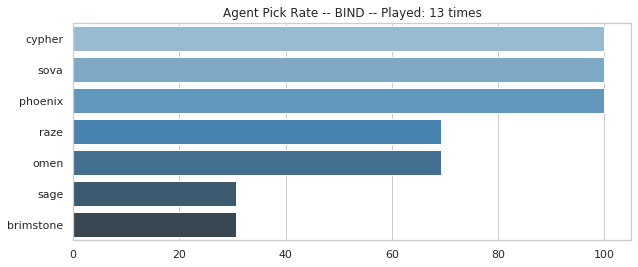

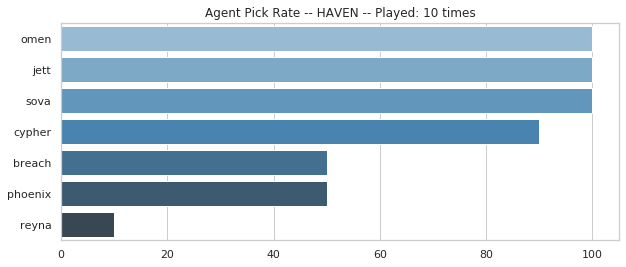

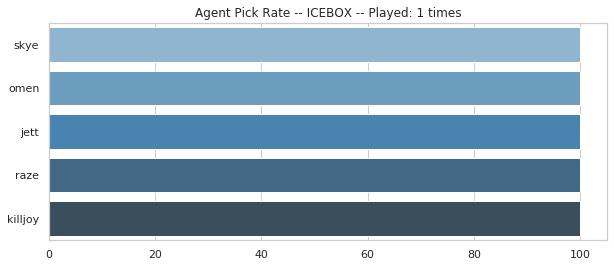

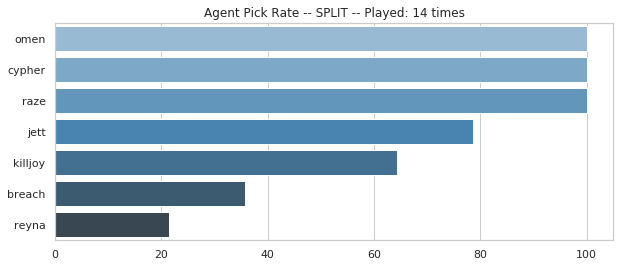

In [30]:
PlotAgentPickRate(maps)